DSN Dec 1, 2021

Network games on a real-world social network that you can play with to test different conditions. 

In [1]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

# Networkx (a python package)
Provides nice ways to draw networks. Nodes are connected by edges.

One way to draw networks is to make the connected nodes closer together. This is called the "spring" layout because it pretends edges are connected like springs.

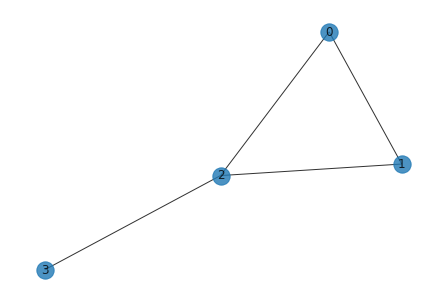

In [2]:
# Network with 4 nodes

G = nx.Graph()
G.add_edge(0, 1)
G.add_edge(1, 2)
G.add_edge(2, 0)
G.add_edge(2, 3)

nx.draw(G, 
        alpha=0.8,        # a little transparent
        with_labels=True) # label nodes with numbers

## DIY 1
Try adding some edges to this network.

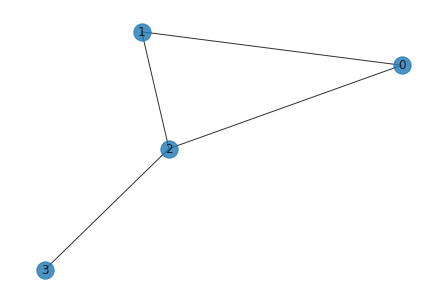

In [3]:
# Hint: Adding an edge between 0 and 3 is
# G.add_edge(0, 3)

# Your code here

nx.draw(G, 
        alpha=0.8,        # a little transparent
        with_labels=True) # label nodes with numbers

# Game theory on a network

Start with a very simple network with only 2 people.

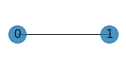

In [4]:
G = nx.Graph()
G.add_edge(0, 1)

# position is a dictionary, {word1: meaning1, word2: meaning2}
# for networkx, the "word" is the "node number"
# and the "meaning" is the "[x,y] position" 
pos = {0:[0,0], 1:[1, 0]}  # a horizontal line

fig, ax = plt.subplots(figsize=[2, 1])
nx.draw(G,
        alpha=0.8,         # a little transparent
        with_labels=True,  # label nodes with numbers
        pos=pos,           # x, y position
        ax=ax)             # where to draw
plt.show()

## Prisoner's dilemma
Pretend 2 people are playing a game. In each round of the game, each person can decide to cheat (be a defector) or to play fairly (be a collaborator). 

### Points
- Both collaborate: Both players win pts_CC=1 point.
- Both defect: No-one gest any points (pts_DD=0)
- Player 0 defects: Player 0 gets pts_DC=1.2 points. Player 1 gets nothing.
- Player 1 defects: Player 0 gets nothing. Player 1 gets pts_DC=1.2 points. 

### What to do next round
- Each player looks at neighbors' points
- Copy the strategy of the neighbor with the highest points
- (Or keep your own strategy if you beat your neighbors)

## Labeling defectors on the network

In [5]:
# Use the role to draw defectors
def draw_defectors(G, role, pos=None, sizes=None, 
                   color_C='lightblue', color_D='pink',
                   figsize=[5, 5]):
    """
    Show which people are defectors vs collaborators
    Inputs:
    -------
        G (networkx graph)
        role (np array): index is node number, 1=defector, 0=collaborator
        
        Optional keyword arguments
        pos (dict): with keys=nodes, values=xyz positions
        sizes (np array): circle size
        color_C (string): color of collaborator
        color_D (string): color of defector
        figsize (list with 2 numbers): how big to make the plot
    No outputs
    """
    colors = []
    for v in G.nodes():
        if role[v] == 1:  
            color = color_D  # defector
        else:
            color = color_C  # collaborator
        colors.append(color)
    # size of circles
    if sizes is None:
        sizes = 200*np.ones(G.number_of_nodes())
    #
    plt.figure(figsize=figsize)
    nx.draw(G, pos=pos, with_labels=True, 
            node_color=colors, 
            alpha=0.8, 
            node_size=sizes)
    plt.show()
    pass

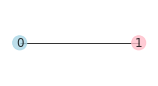

Player 0 is a collaborator (blue).
Player 1 is a defector (pink)


In [6]:
# Make player 0 a collaborator and player 1 a defector
roles = np.array([0, 1])
draw_defectors(G, 
               roles,    # defector or collaborator
               pos=pos,  # x, y position
               figsize=[2, 1])  # how big to make plot

print('Player 0 is a collaborator (blue).')
print('Player 1 is a defector (pink)')

## Get points by playing the game

In [7]:
def get_points(G, role, pts_DD=0, pts_DC=1.2, pts_CC=1):
    """Return points after a round of Prisoner's Dilemma on
    on a network. Only people connec by an edge can play
    against each other. 
    
    Inputs:
    ------
        G (networkx graph)
        role (np array): 0=collaborator, 1=defector. 
        pts should all be positive
    Sum of each pair of people.
    Rules:
        - sum=2 -> both lose     -> each gets pts_DD
        - sum=1 -> defector wins -> defector gets pts_DC
        - sum=0 -> both win      -> each gets pts_CC
    """
    points = np.zeros(G.number_of_nodes())
    edge_list = list(G.edges()) 
    for edge in edge_list:
        i, j = edge                   # persons i and j
        role_edge = role[list(edge)]  # defector=1 or collaborator=0?
        sum_edge = sum(role_edge)     # sum of each pair of people
        # examine interaction based on sum 
        if sum_edge == 0:
            points[i] += pts_CC  # both collaboration
            points[j] += pts_CC
        elif sum_edge == 2:
            points[i] += pts_DD
            points[j] += pts_DD  # both defect
        else:
            if role[i] == 1: # i is defector
                points[i] += pts_DC
            else:            # j is defector
                points[j] += pts_DC
    return points

Player 0 (collaborator, role=0) has 0.0 points.
Player 1 (defector, role=1) has 1.2 points.


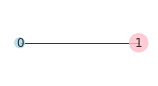

Player 1 is winning (larger circle).


In [8]:
# get points after one round of the game where player 1
# cheats player 0
points = get_points(G, roles, pts_DC=1.2)
print(f'Player 0 (collaborator, role={roles[0]}) has {points[0]} points.')
print(f'Player 1 (defector, role={roles[1]}) has {points[1]} points.')

draw_defectors(G, 
               roles,  # 1=defector=pink, 0=collaborator=blue 
               pos=pos,  # xy position
               sizes=(100+points*200),  # winners have bigger circles
               figsize=[2,1])

print('Player 1 is winning (larger circle).')

## Choose strategy for next round

In [9]:
def get_new_mutrole(G, role, points, p_m=0):
    """
    Return the strategy in the next round.
    Adopt the strategy of whoever is winning of your neighbors. 
    If you beat all your neighbors, keep your strategy. Make an
    error in your calculations at rate p_m.
    
    Inputs:
    ------
        G (networkx graph)
        role (np array): 0=collaborator, 1=defector. 
        points (np array): score, not normalized
        p_m (double): probability of error
    """
    new_role = np.zeros(len(role))
    for player in range(G.number_of_nodes()):
        # Get node numbers for self+neighbors
        n_list = [n for n in G.neighbors(player)]
        n_list.append(player)
        # For self+neighbors, get points and roles
        n_pts = points[n_list]  # points
        n_roles = role[n_list]  # defector or collaborator roles
        #
        # identify a winner
        max_pts = max(n_pts)
        all_winners_index = np.argwhere(n_pts==max_pts).flatten()
        all_winners_players = np.array(n_list)[all_winners_index]
        all_winners_roles = n_roles[all_winners_index]
        # select 1 winner
        # winner = np.random.choice(all_winners_players)
        winner = all_winners_players[0]  # choose self
        winner_role = role[winner]
        # add randomness 
        if np.random.rand() < p_m:
            new_role[player] = (winner_role + 1) % 2
        else:
            new_role[player] = winner_role 
    return new_role

In [10]:
# Get new roles based on points
new_roles = get_new_mutrole(G, roles, points)

Previous round


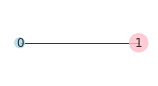

Roles in next round
Player 0 will be a defector in the next round.
Player 1 remains a defector


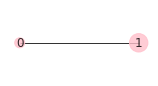

In [11]:
print('Previous round')
draw_defectors(G, 
               roles,  # old role
               pos=pos,  # xy position
               sizes=(100+points*200),  # winners have bigger circles
               figsize=[2,1])

print('Roles in next round')
print('Player 0 will be a defector in the next round.')
print('Player 1 remains a defector')
draw_defectors(G, 
               new_roles,  # role in next round
               pos=pos,  # xy position
               sizes=(100+points*200),  # winners have bigger circles
               figsize=[2,1])# circle size



## Play again

This round


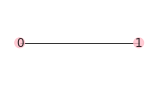

Next round


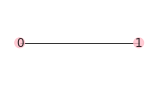

In [12]:
roles = new_roles
points = get_points(G, roles)
print('This round')
draw_defectors(G, 
               roles,  # this round
               pos=pos,  
               sizes=(100+points*200),  # winners have bigger circles
               figsize=[2,1])

new_roles = get_new_mutrole(G, roles, points)

print('Next round')
draw_defectors(G, 
               new_roles, # next round
               pos=pos,  
               sizes=(100+points*200),  
               figsize=[2,1])

Since both players are defectors, no-one gets any points :( 

If players choose their strategy with no error, the game very quickly becomes stuck. As a result, players artificially have an error rate, p_m, which can be set in get_new_mutrole. The default is p_m=0 (no error). 

## Play several rounds, with high error
p_m = 0.1 means 1 in 10 strategy choices will be wrong.

Initialization


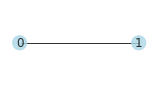

Round 1


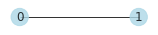

Round 2


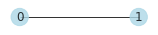

Round 3


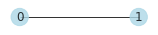

Round 4


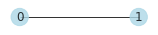

Round 5


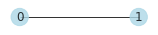

Round 6


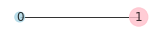

Round 7


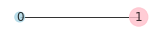

Round 8


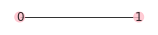

Round 9


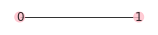

Round 10


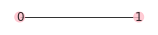

Round 11


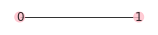

Round 12


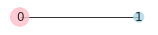

Round 13


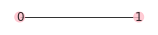

Round 14


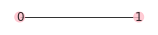

Round 15


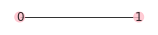

Round 16


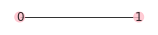

Round 17


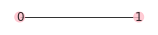

Round 18


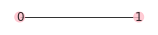

Round 19


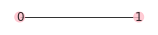

Round 20


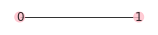

In [13]:
# Simple network
G = nx.Graph()
G.add_edge(0, 1)
pos = {0:[0,0], 1:[1, 0]}  # a horizontal line

# Try playing with these variables
pts_DC = 1.2  # points won by defector, >0
pts_CC = 1    # points for collaborating, >0
p_m = 0.1     # error rate when choosing strategy

# Start the game with 2 collaborators
roles = np.array([0, 0])  # 2 collaborators
print('Initialization')
draw_defectors(G, roles, pos=pos, figsize=[2, 1])

num_games = 20
for game in range(num_games):
    print(f'Round {game + 1}')
    points = get_points(G, 
                        roles, 
                        pts_DC=pts_DC,  # defector-collaborator
                        pts_CC=pts_CC)  # 2 collaborators
    circle_sizes = 100+points*200
    draw_defectors(G, roles, pos=pos, 
                   sizes=circle_sizes,
                   figsize=[2, 0.3])
    new_roles = get_new_mutrole(G, roles, points, p_m=p_m)
    roles = new_roles  # next round

## DIY 2 Try changing the conditions in a simple system
In the cell above, try changing things
- always choose the 'wrong' strategy: p_m=1
- defectors lose: pts_DC=0.1 (default pts_DC=1.2)
- collaborators win: pts_CC=1.5 (default pts_CC=1)

# A real network
In the 70s, the 34 people in a karate club had a schism and separated (described by Wayne Zachary). Network scientists wanted to see whether the social network could explain which friendships were lost in the schism.

More information: https://en.wikipedia.org/wiki/Zachary%27s_karate_club

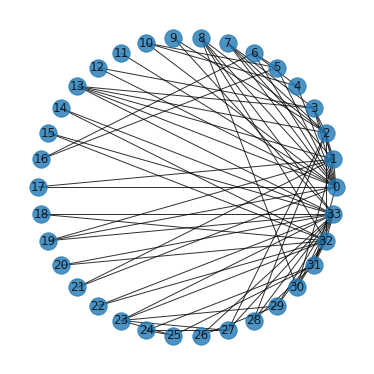

In [14]:
# Load the network
G = nx.karate_club_graph()

# Draw the network
plt.figure(figsize=[5, 5])
nx.draw_circular(G, 
                 alpha=0.8,         # slightly transparent
                 with_labels=True)  # number the nodes
plt.show()

For a prettier network, let's place the nodes that are connected to each other, closer together. And colour the nodes based on the number of neighbours. 

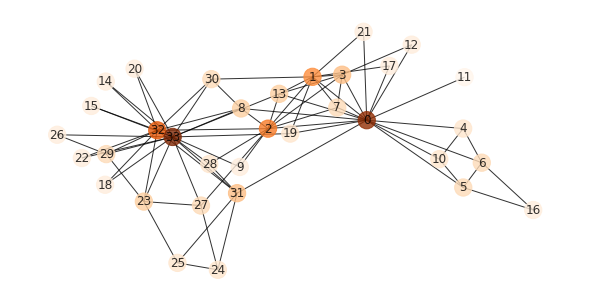

In [18]:
# x, y positions as if each connection was a spring
pos = nx.spring_layout(G)

# degree centrality
centrality = nx.degree_centrality(G)
centrality_list = list(centrality.values())


plt.figure(figsize=[8, 4])
nx.draw(G, 
        pos=pos,           # x, y position
        node_color=centrality_list,
        cmap='Oranges',
        alpha=0.8,         # slightly transparent
        with_labels=True)  # number the nodes
plt.show()

## DIY 3 find a nice visualization of the network
The positions are selected randomly, so you may have to try running the cell above several times until you are happy with the picture.

## DIY 4 find the most popular person

In [19]:
# Try changing the person
person = 27
n_list = [n for n in G.neighbors(person)]
print(f"person {person} has neighbors {n_list}")
print(f"person {person} has a total of {len(n_list)} neighbors")
print(f"person {person} has degree centrality {centrality[person] :.3f}")

person 27 has neighbors [2, 23, 24, 33]
person 27 has a total of 4 neighbors
person 27 has degree centrality 0.121


## Draw by centrality function
For convenience, let's make the coloring by centrality a function. Maybe you can think of a way to use it later.

In [20]:
def draw_centrality(G, pos=None, figsize=[5, 5]):
    """
    Show centrality as heatmap
    Inputs:
    -------
        G (networkx graph)
        
        Optional keyword arguments
        pos (dict): with keys=nodes, values=xyz positions
        figsize (list with 2 numbers): how big to make the plot
    No outputs
    """
    # degree centrality
    centrality = nx.degree_centrality(G)
    centrality_list = list(centrality.values())
    # draw
    plt.figure(figsize=figsize)
    nx.draw(G, 
            pos=pos,           # x, y position
            node_color=centrality_list,
            cmap='Oranges',
            alpha=0.8,         # slightly transparent
            with_labels=True)  # number the nodes
    plt.show()
    pass

## Randomly assign roles
Some will be defectors and some will be collaborators

In [21]:
# Randomly assign players to be defectors
num_D = 1  # number of defectors
N = G.number_of_nodes()
roles = np.zeros(N)  # initialize all as 0=collaborators
ind_Ds = np.random.choice(range(N), num_D)  # defectors
for ind in ind_Ds:
    roles[ind] = 1  # make defectors 1

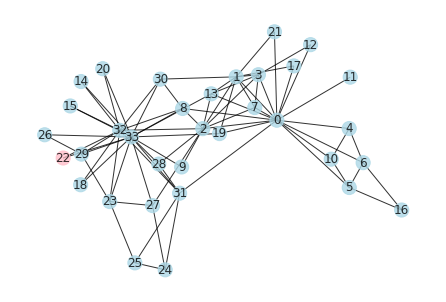

In [22]:
draw_defectors(G, roles, pos=pos, figsize=[6, 4])

For convenience, let's make this a function that we can call anytime we want to restart the game.

In [27]:
def random_karateclub(num_D=1):
    """
    Get variables to start a game for karate club network.
    Inputs:
    -------
        num_D (int): number of defectors <= 34
        
    Outputs:
    --------
        G (networkx graph): karate club network
        roles (np array): defectors=1, collaborators=0
    """
    print(f'Init: {num_D} defectors')
    G = nx.karate_club_graph()
    N = G.number_of_nodes()
    # check that user input num_D is reasonable
    if num_D > N:
        num_D = N
        print('num_D should be less than the number of nodes.')
        print(f'setting num_D={N} nodes in karate club')
    else:
        num_D = int(num_D)
    # assign num_D defectors
    roles = np.zeros(N)  # initialize all as 0=collaborators
    ind_Ds = np.random.choice(range(N), num_D)  # defectors
    for ind in ind_Ds:
        roles[ind] = 1  # make defectors
    return G, roles

Init: 10 defectors


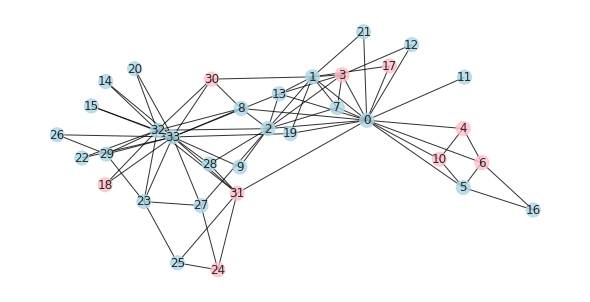

In [28]:
num_D = 10
G, roles = random_karateclub(num_D)
draw_defectors(G, roles, pos=pos, figsize=[8, 4])

# Play a round

Init: 5 defectors
Initialization


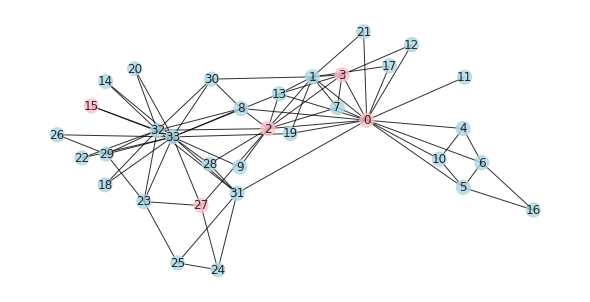

Round 1


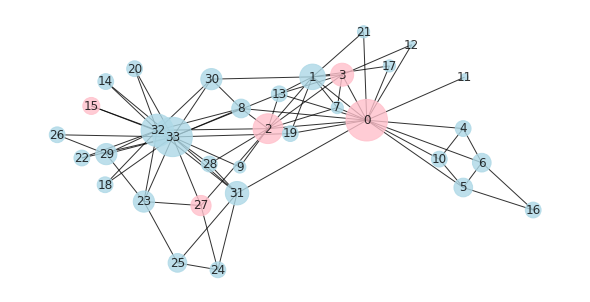

Strategy for next round


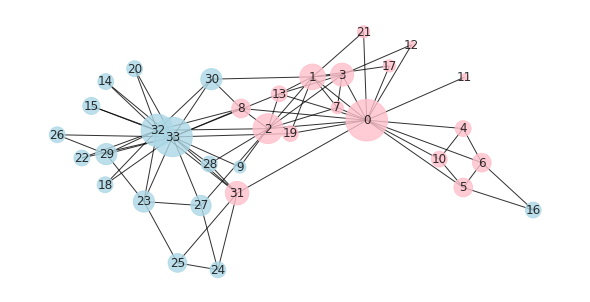

In [32]:
num_D = 5  # number of defectors
G, roles = random_karateclub(num_D)
print('Initialization')
draw_defectors(G, roles, pos=pos, figsize=[8, 4])

# Try playing with these variables
pts_DC = 1.2  # points won by defector, >0
pts_CC = 1    # points for collaborating, >0
p_m = 0     # error rate when choosing strategy

print('Round 1')
# calculate points
points = get_points(G, roles, 
                    pts_DC=pts_DC, 
                    pts_CC=pts_CC)
# show what happened
draw_defectors(G, roles, 
               pos=pos,
               sizes=points*100+50, 
               figsize=[8, 4])
# choose new strategy
new_roles = get_new_mutrole(G, roles, points, 
                            p_m=p_m)


print('Strategy for next round')
draw_defectors(G, new_roles, 
               pos=pos,
               sizes=points*100+50, 
               figsize=[8, 4])

## DIY 5: Try changing the conditions in this network

In the cell above, try changing things
- chose strategy with error, p_m=0.1
- defectors win a lot: pts_DC=4 (default pts_DC=1.2)
- collaborators win a lot: pts_CC=4 (default pts_CC=1)
- start with all defectors: num_D = 34

# Play several rounds
Keep track of:
- number of defectors
- history of the game

Init: 0 defectors
Initialization


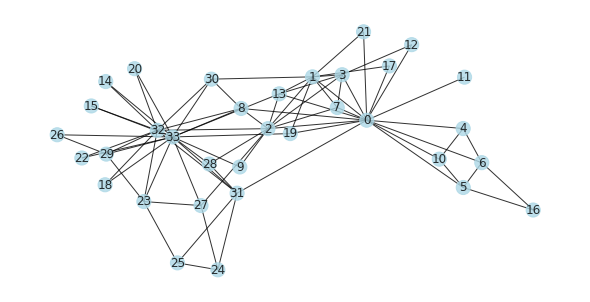

Round 1


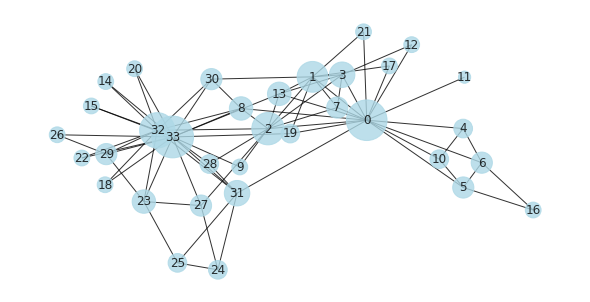

Round 2


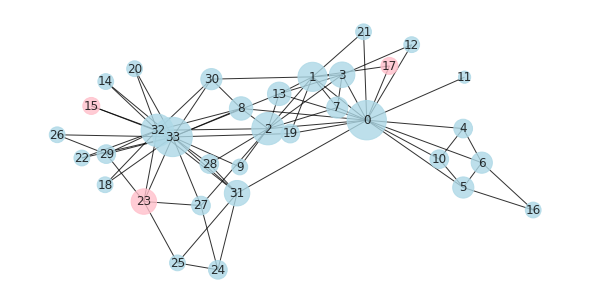

Round 3


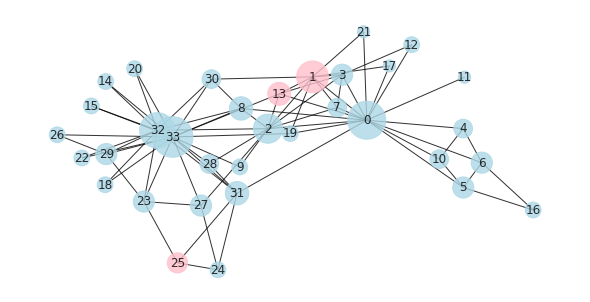

Round 4


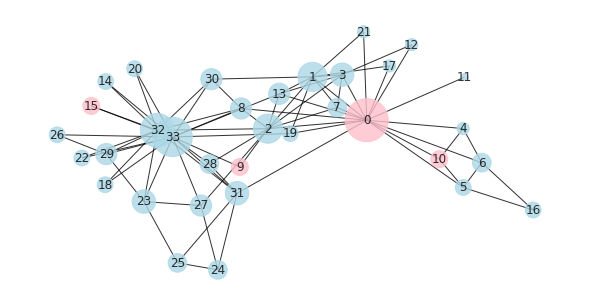

Round 5


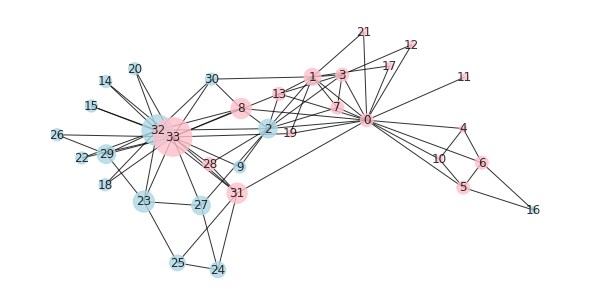

Round 6


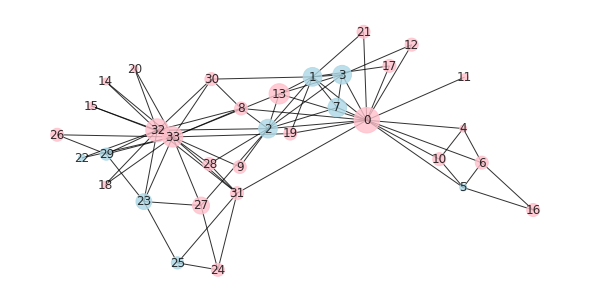

Round 7


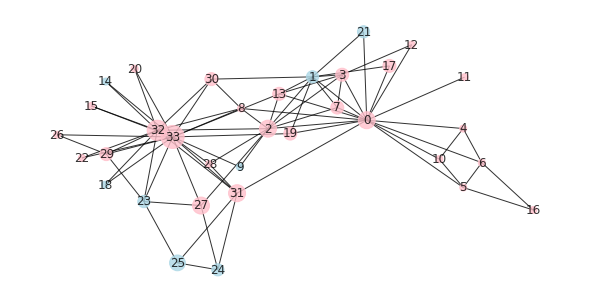

Round 8


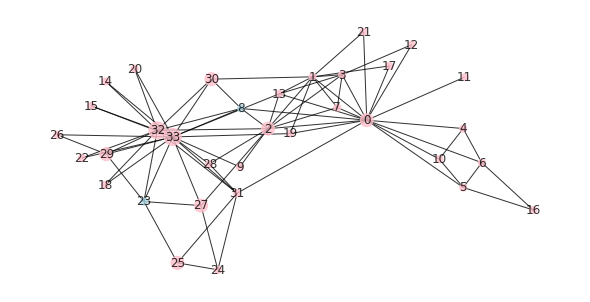

Round 9


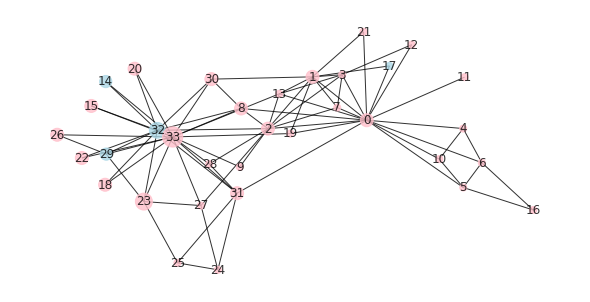

Round 10


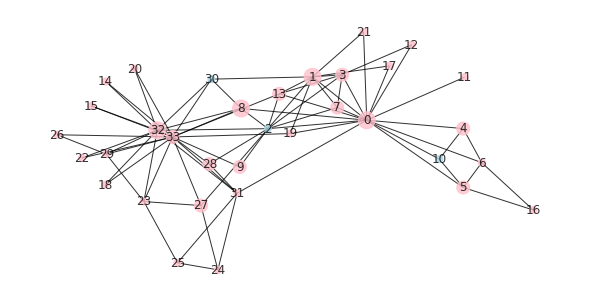

Round 11


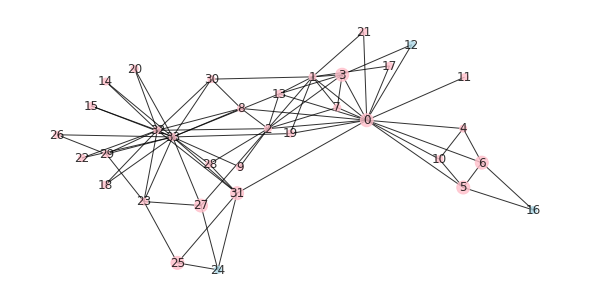

Round 12


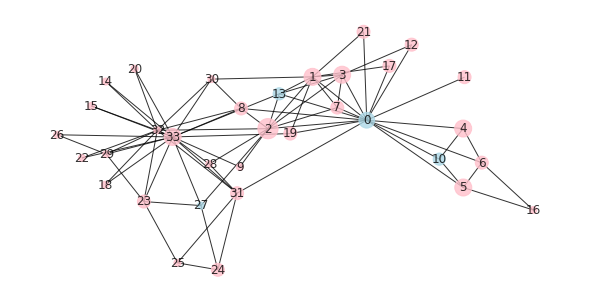

In [33]:
G, roles = random_karateclub(0)  # start with 0 defectors
print('Initialization')
draw_defectors(G, roles, pos=pos, figsize=[8, 4])

# Try playing with these variables
pts_DC = 1.2  # points won by defector, >0
pts_CC = 1    # points for collaborating, >0
p_m = 0.1     # error rate when choosing strategy
num_games = 12

# Tracking history and number of defectors
history = np.zeros([num_games + 1, G.number_of_nodes()])
history[0, :] = roles
num_defectors = np.zeros(num_games + 1)
num_defectors[0] = sum(roles)

# Play game!
for game in range(num_games):
    print(f'Round {game + 1}')
    # calculate points
    points = get_points(G, roles, 
                    pts_DC=pts_DC, 
                    pts_CC=pts_CC)
    # show what happened
    draw_defectors(G, roles, 
               pos=pos,
               sizes=points*100+50, 
               figsize=[8, 4])
    # choose new strategy
    new_roles = get_new_mutrole(G, roles, 
                                points, 
                                p_m=p_m)
    roles = new_roles
    # track information
    history[game + 1, :] = roles
    num_defectors[game + 1] = np.sum(roles)

Here is a way to show the history and the number of defectors.

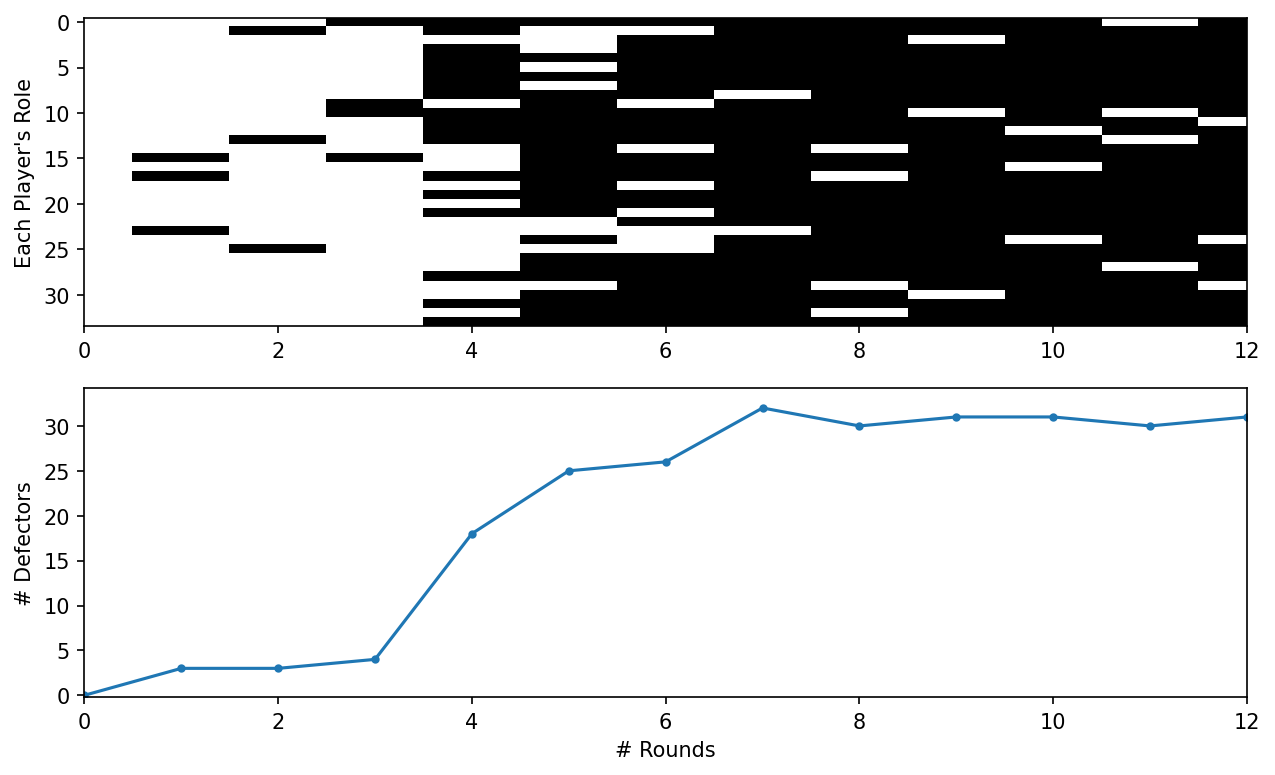

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[10, 6],
                               dpi=150)

ax1.imshow(history.T, cmap='Greys', aspect='auto')
ax2.plot(num_defectors, '.-')
ax2.set_ylim([0-0.2, G.number_of_nodes()+0.2])
for ax in [ax1, ax2]:
    ax.set_xlim([0, num_games])
#
ax1.set_ylabel("Each Player's Role")
ax2.set_xlabel('# Rounds')
ax2.set_ylabel('# Defectors')
plt.show()

# Play a bunch of games
You probably get the point by now, so let's only show the network every couple of games.

Init: 0 defectors
Initialization


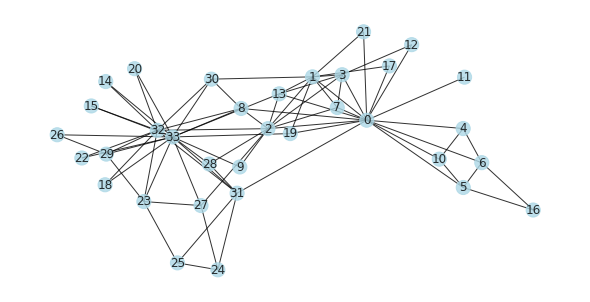

Round 20


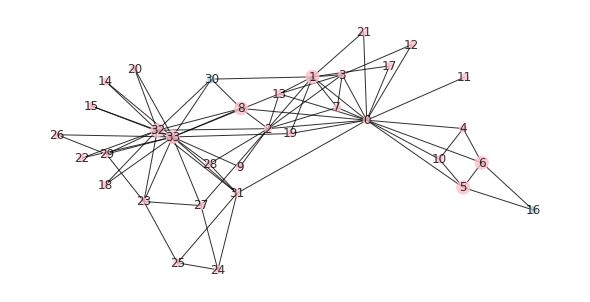

Round 40


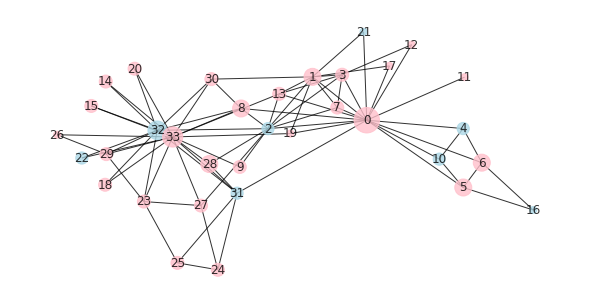

Round 60


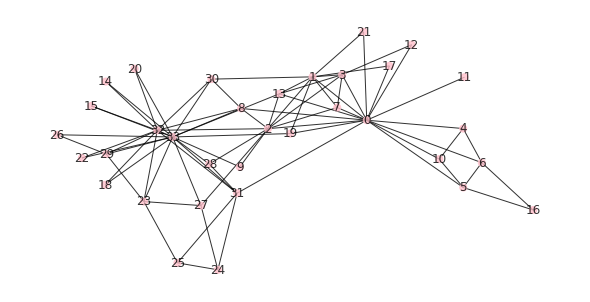

Round 80


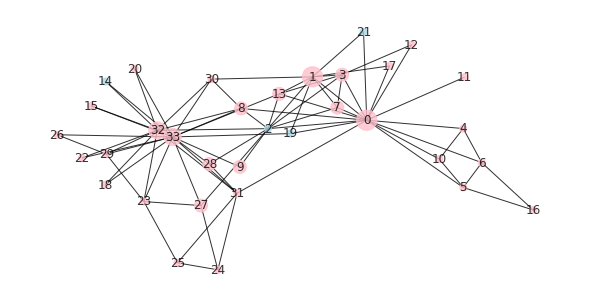

Round 100


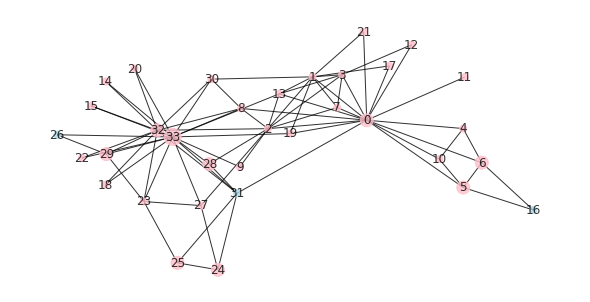

Round 120


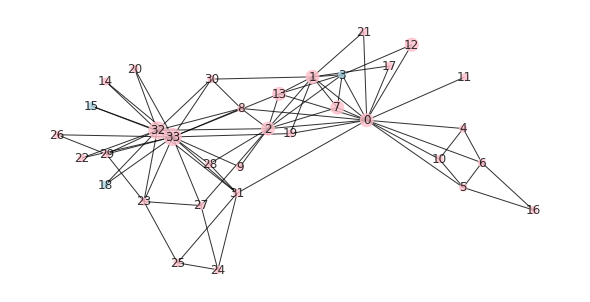

Round 140


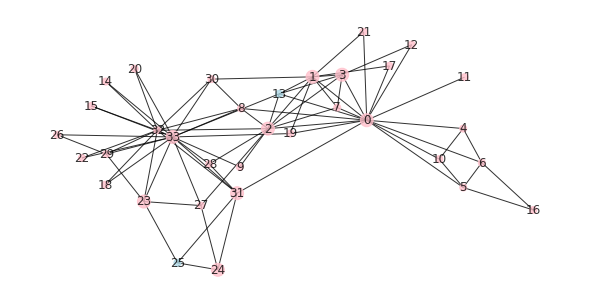

Round 160


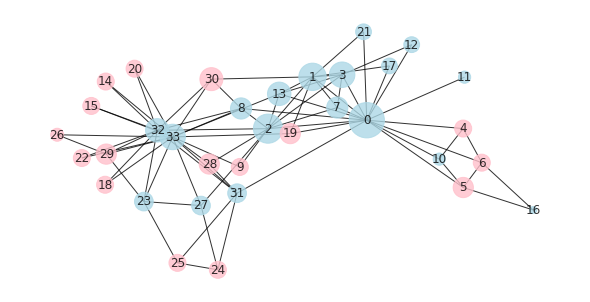

Round 180


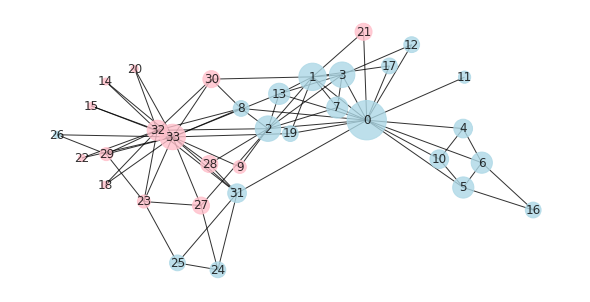

Round 200


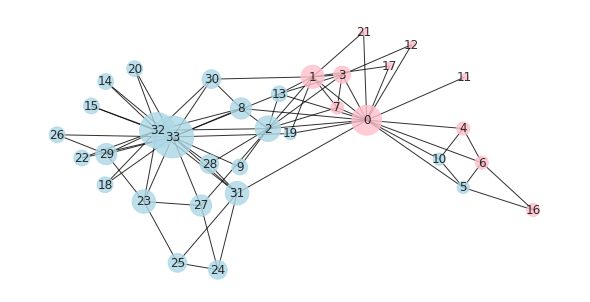

In [37]:
num_D = 0
G, roles = random_karateclub(num_D)  # start with 0 defectors
print('Initialization')
draw_defectors(G, roles, pos=pos, figsize=[8, 4])

# Try playing with these variables
pts_DC = 1.2  # points won by defector, >0
pts_CC = 1    # points for collaborating, >0
p_m = 0.1     # error rate when choosing strategy
num_games = 200
show_games = 20

# Tracking history and number of defectors
history = np.zeros([num_games + 1, G.number_of_nodes()])
history[0, :] = roles
num_defectors = np.zeros(num_games + 1)
num_defectors[0] = sum(roles)

# Play game!
for game in range(num_games):
    # calculate points
    points = get_points(G, roles, 
                    pts_DC=pts_DC, 
                    pts_CC=pts_CC)
    # show what happened every few rounds
    if (game+1) % show_games == 0:
        print(f'Round {game + 1}')
        draw_defectors(G, roles, 
                   pos=pos,
                   sizes=points*100+50, 
                   figsize=[8, 4])
    # choose new strategy
    new_roles = get_new_mutrole(G, roles, 
                                points, 
                                p_m=p_m)
    roles = new_roles
    # track information
    history[game + 1, :] = roles
    num_defectors[game + 1] = np.sum(roles)

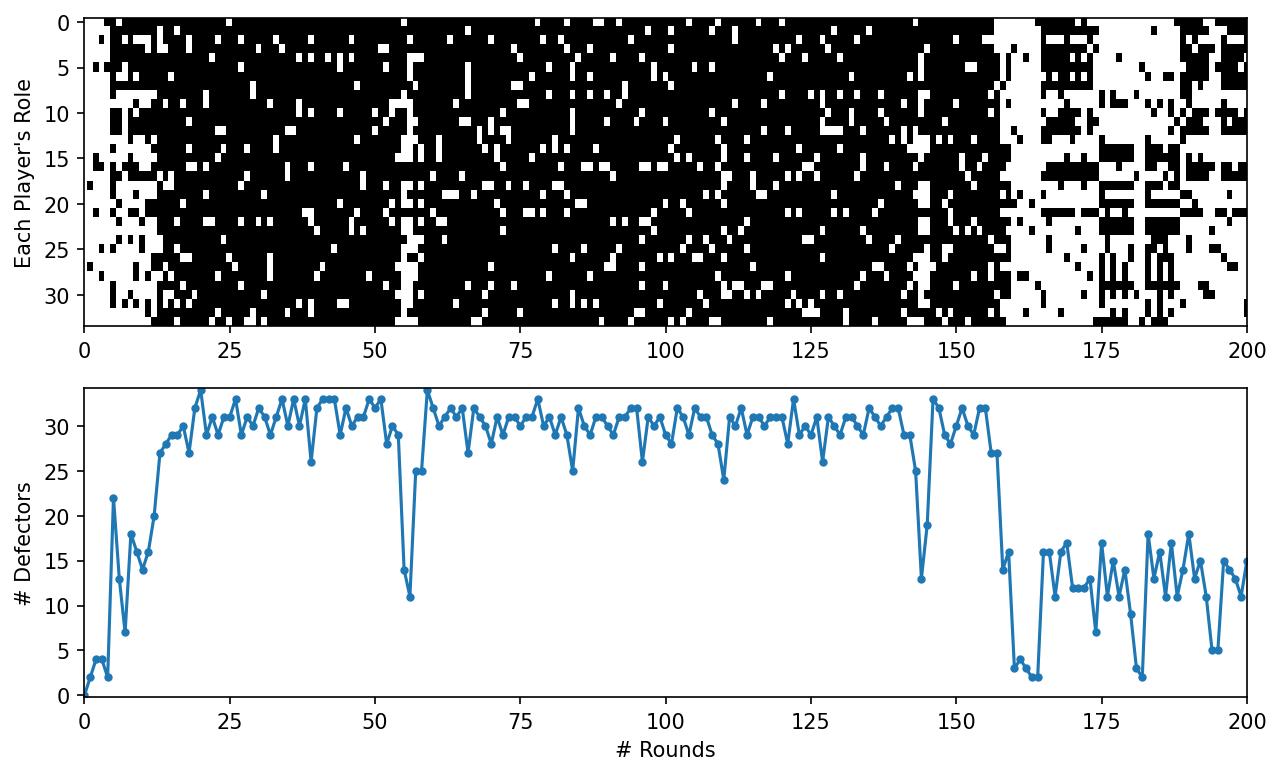

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[10, 6],
                               dpi=150)

ax1.imshow(history.T, cmap='Greys', aspect='auto')
ax2.plot(num_defectors, '.-')
ax2.set_ylim([0-0.2, G.number_of_nodes()+0.2])
for ax in [ax1, ax2]:
    ax.set_xlim([0, num_games])
#
ax1.set_ylabel("Each Player's Role")
ax2.set_xlabel('# Rounds')
ax2.set_ylabel('# Defectors')
plt.show()

## DIY 6 Try changing the conditions for games with more rounds

# Play a LOT of games
Eventually, it makes more sense to only keep track of the number of defectors.

Init: 0 defectors
Initialization


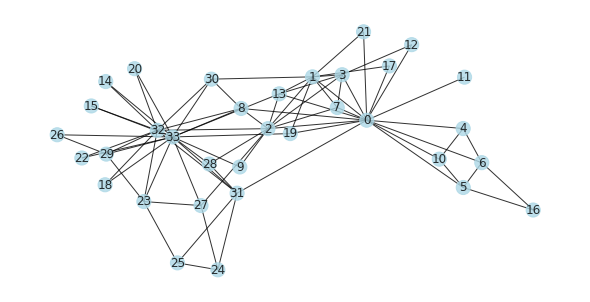

Round 1000


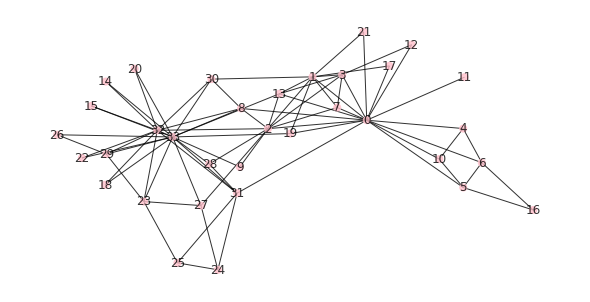

Round 2000


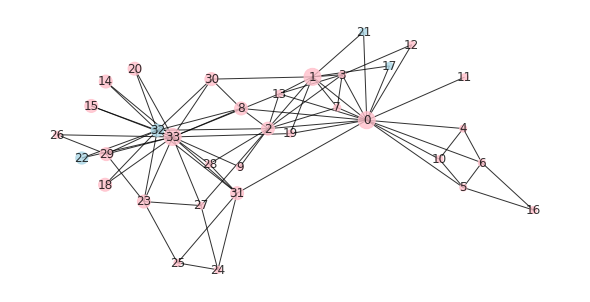

Round 3000


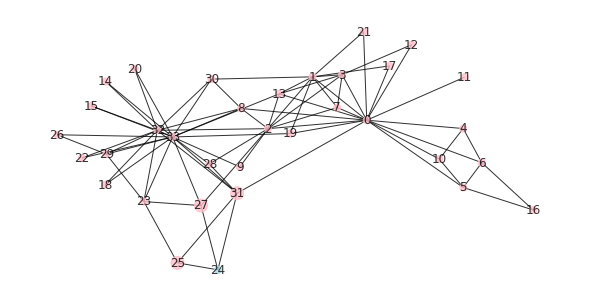

Round 4000


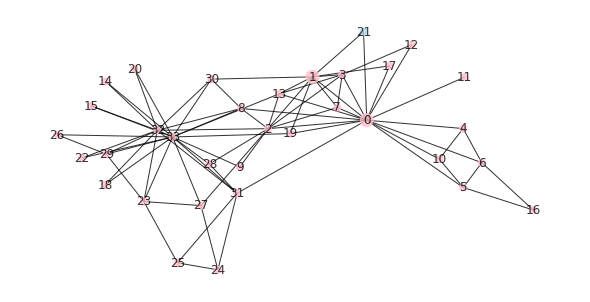

Round 5000


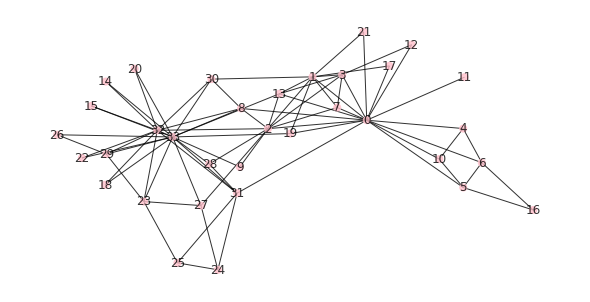

Round 6000


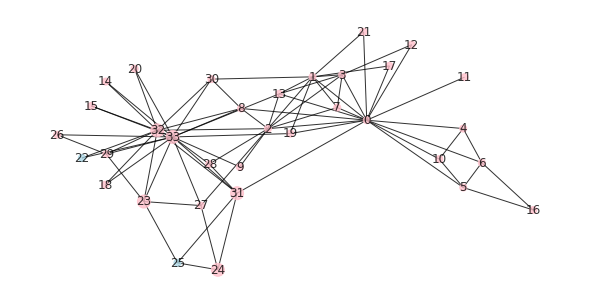

Round 7000


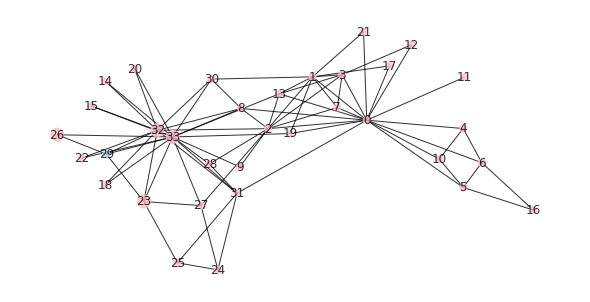

Round 8000


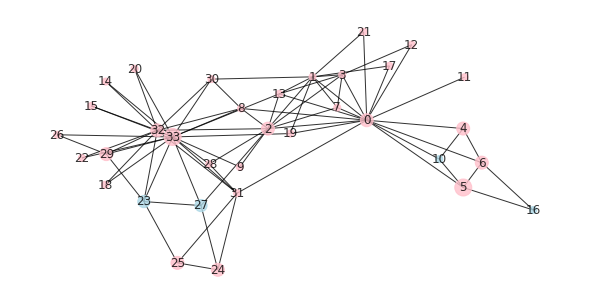

Round 9000


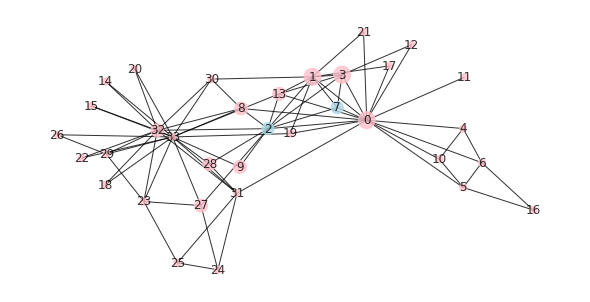

Round 10000


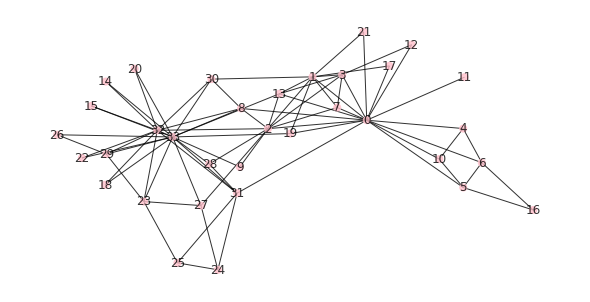

In [49]:
num_D = 0
G, roles = random_karateclub(num_D)  # start with 0 defectors
print('Initialization')
draw_defectors(G, roles, pos=pos, figsize=[8, 4])

# Try playing with these variables
pts_DC = 1.2  # points won by defector, >0
pts_CC = 1    # points for collaborating, >0
p_m = 0.05     # error rate when choosing strategy
num_games = 10**4
show_games = int(num_games) / 10

# ONLY track number of defectors
num_defectors = np.zeros(num_games + 1)
num_defectors[0] = sum(roles)

# Play game!
for game in range(num_games):
    # calculate points
    points = get_points(G, roles, 
                    pts_DC=pts_DC, 
                    pts_CC=pts_CC)
    # show what happened every few rounds
    if (game+1) % show_games == 0:
        print(f'Round {game + 1}')
        draw_defectors(G, roles, 
                   pos=pos,
                   sizes=points*100+50, 
                   figsize=[8, 4])
    # choose new strategy
    new_roles = get_new_mutrole(G, roles, 
                                points, 
                                p_m=p_m)
    roles = new_roles
    # track information
    num_defectors[game + 1] = np.sum(roles)

## Zooming in

In [40]:
# Find timepoints with no defectors
no_defect = np.argwhere(np.array(num_defectors) == 0).flatten()
dt_no_defect = np.diff(no_defect)
dt_no_defect
no_defect
print(f'{len(no_defect)} games with no defectors')

86 games with no defectors


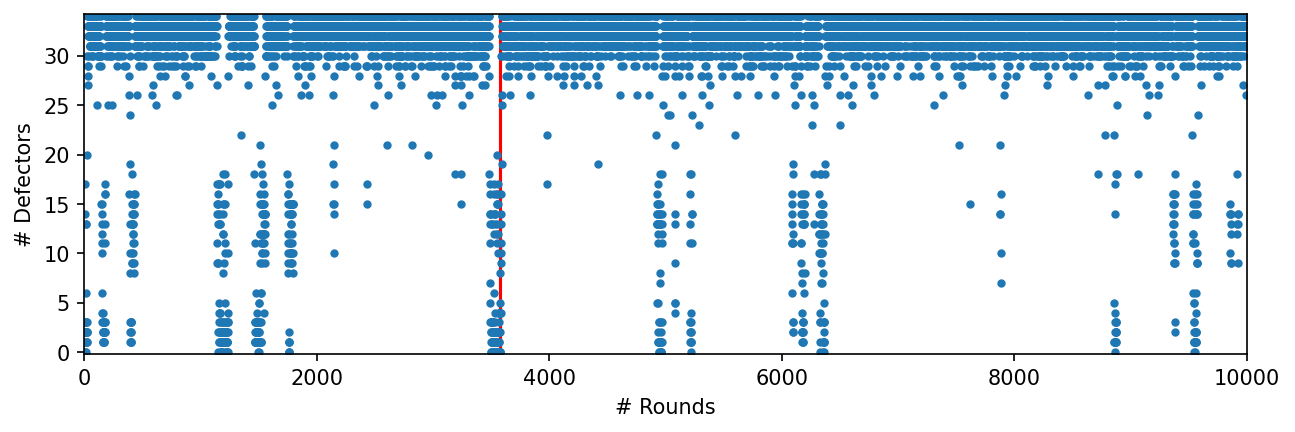

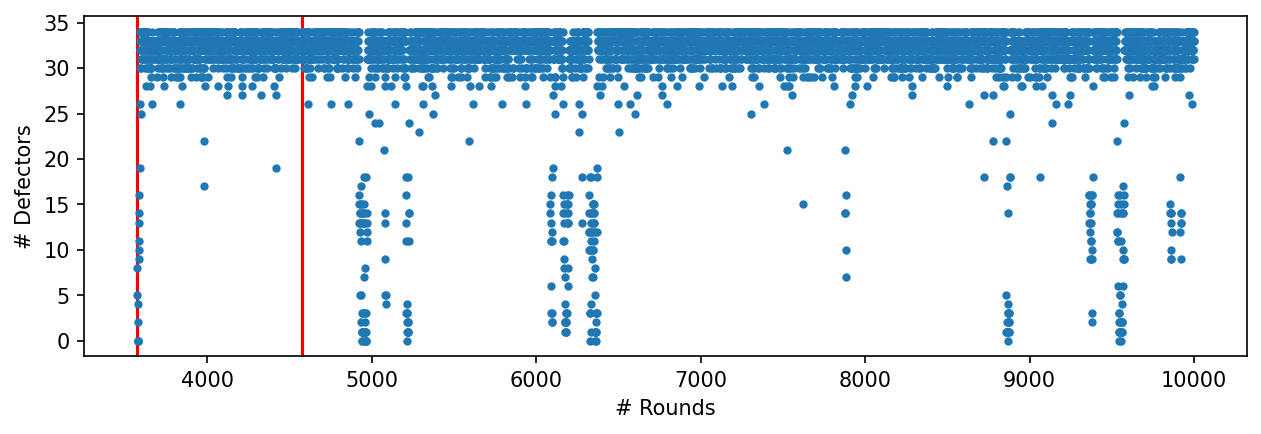

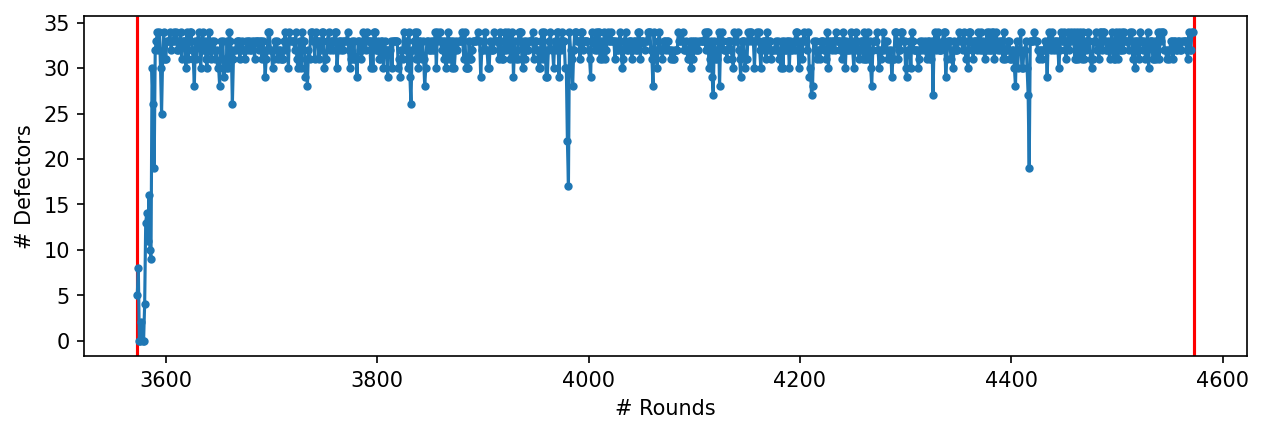

In [51]:
x0 = no_defect[44]
dt1 = int(1*10**4)
dt2 = int(1*10**3)

# Zoomed out view
t = np.array(range(len(num_defectors)))
fig, ax = plt.subplots(1, 1, figsize=[10, 3],
                               dpi=150)

ax.plot(t, num_defectors, '.')
ax.set_ylim([0-0.2, G.number_of_nodes()+0.2])
ax.set_xlim([0, num_games])
ax.set_xlabel('# Rounds')
ax.set_ylabel('# Defectors')
ymin, ymax = ax.get_ylim()
ax.vlines([x0, x0 + dt1], ymin, ymax, color='r')
ax.set_ylim([ymin, ymax])
plt.show()

# Zoom in
fig, ax = plt.subplots(1, 1, figsize=[10, 3],
                               dpi=150)
ax.plot(t[x0:x0+dt1],
        num_defectors[x0:x0+dt1], 
        '.')
ax.set_xlabel('# Rounds')
ax.set_ylabel('# Defectors')
ymin, ymax = ax.get_ylim()
ax.vlines([x0, x0 + dt2], ymin, ymax, color='r')
ax.set_ylim([ymin, ymax])
plt.show()

# Zoom in even more
fig, ax = plt.subplots(1, 1, figsize=[10, 3],
                               dpi=150)
ax.plot(t[x0:x0+dt2],
        num_defectors[x0:x0+dt2], 
        '.-')
ax.set_xlabel('# Rounds')
ax.set_ylabel('# Defectors')
ymin, ymax = ax.get_ylim()
ax.vlines([x0, x0 + dt2], ymin, ymax, color='r')
ax.set_ylim([ymin, ymax])
plt.show()

# What if you change the network too?

In [56]:
def rewire_lowest_randomly(G, points):
    # find player with lowest score
    lowest_score = np.min(points)
    loser = find_player_by_pointvalue(points, lowest_score)
    # check if there is at least 1 neighbor
    n_list = [n for n in G.neighbors(loser)]
    output = []
    if len(n_list) > 0:
        # select node to remove
        remove_node = np.random.choice(n_list)
        # select node to add
        all_players = [n for n in G.nodes]
        n_and_self = n_list + [loser]
        strangers = list_difference(all_players, n_and_self)
        add_node = np.random.choice(strangers)
        # rewire by cutting edge with remove_node and
        # adding edge to add_node
        rewire_network(G, loser, remove_node, add_node)
        output = [loser, remove_node, add_node]
    return G, output
        
    
def find_player_by_pointvalue(points, target):
    """Returns an index with point=target."""
    inds = np.argwhere(points==target).flatten()
    ind = np.random.choice(inds)
    return ind

def list_difference(list1, list2):
    """Remove elements of list2 from list1"""
    diff_set = set(list1).difference(list2)
    return list(diff_set)

def rewire_network(G, node, removed, added):
    cut_edge_exists = G.has_edge(node, removed)
    can_add_edge = not G.has_edge(node, added)
    if cut_edge_exists and can_add_edge:
        G.remove_edge(node, removed)
        G.add_edge(node, added)
    else:
        pass
    return G.copy()

Init: 1 defectors
Initialization


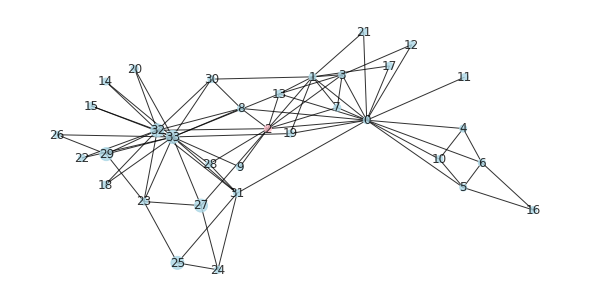

Round 1


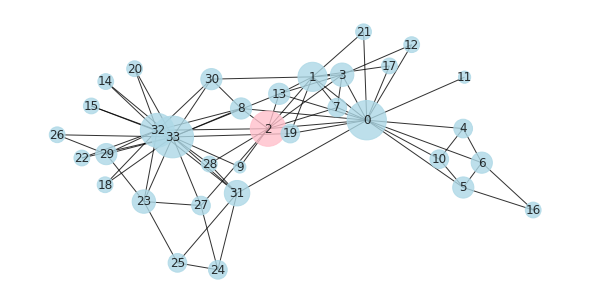

New strategy


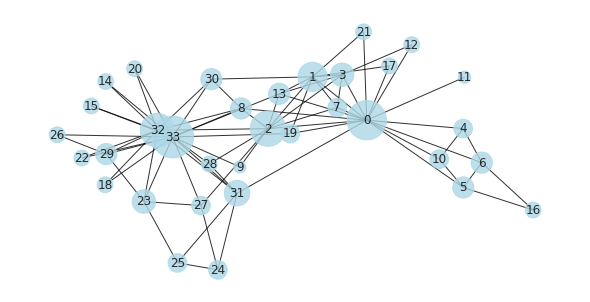

In [43]:
G, roles = random_karateclub(1)

print('Initialization')
draw_defectors(G, roles, 
               pos=pos,
               sizes=points*100+50, 
               figsize=[8, 4])

# Play a round of the game

# Try playing with these variables
pts_DC = 1.2  # points won by defector, >0
pts_CC = 1    # points for collaborating, >0
p_m = 0.0     # error rate when choosing strategy

print('Round 1')
# calculate points
points = get_points(G, roles, 
                    pts_DC=pts_DC, 
                    pts_CC=pts_CC)
# show what happened
draw_defectors(G, roles, 
               pos=pos,
               sizes=points*100+50, 
               figsize=[8, 4])

# choose new strategy
new_roles = get_new_mutrole(G, roles, points, 
                            p_m=p_m)

# show new strategy
print('New strategy')
draw_defectors(G, new_roles, 
               pos=pos,
               sizes=points*100+50, 
               figsize=[8, 4])

Node 11: cut 0, added 12
Rewired network with new strategy


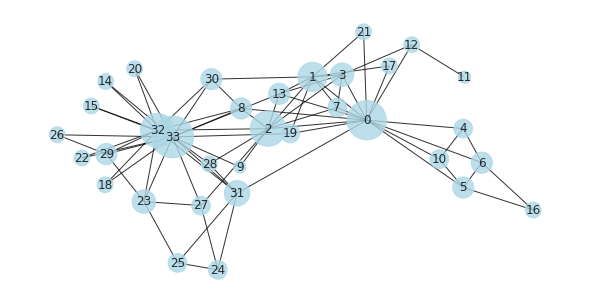

In [44]:
# Rewire network

new_G, output = rewire_lowest_randomly(G, points)

loser, removed, added = output
print(f'Node {loser}: cut {removed}, added {added}')
print('Rewired network with new strategy')
draw_defectors(new_G, new_roles, 
               pos=pos,
               sizes=points*100+50, 
               figsize=[8, 4])

## Play a couple rounds with rewiring

Init: 1 defectors
Initialization


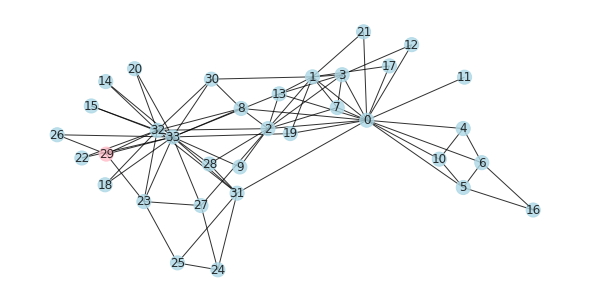

Round 50


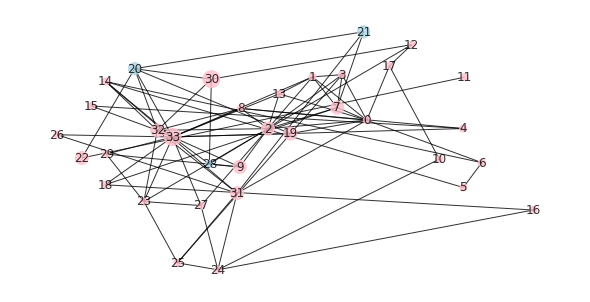

Round 100


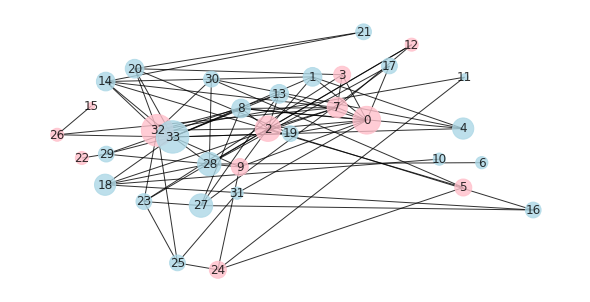

Round 150


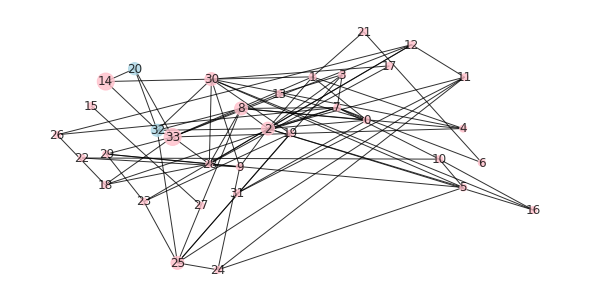

Round 200


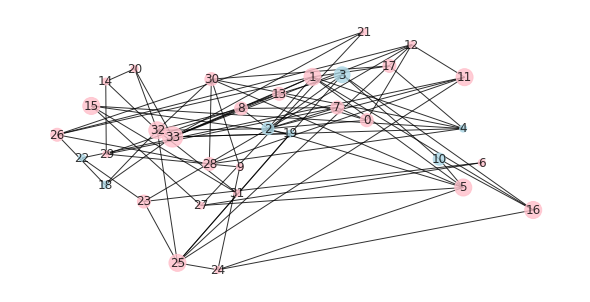

In [61]:
num_D = 1
G, roles = random_karateclub(num_D)  # start with num_D
G_unrewired = G.copy()  # make a copy for comparison later
verbose = False  # verbose=False means don't list outputs

print('Initialization')
draw_defectors(G, roles, pos=pos, figsize=[8, 4])

# Try playing with these variables
pts_DC = 1.2  # points won by defector, >0
pts_CC = 1    # points for collaborating, >0
p_m = 0.1     # error rate when choosing strategy
num_games = 200
show_games = 50

# Tracking history and number of defectors
history = np.zeros([num_games + 1, G.number_of_nodes()])
history[0, :] = roles
num_defectors = np.zeros(num_games + 1)
num_defectors[0] = sum(roles)

# Play game!
for game in range(num_games):
    # calculate points
    points = get_points(G, roles, 
                    pts_DC=pts_DC, 
                    pts_CC=pts_CC)
    # show what happened every few rounds
    if (game+1) % show_games == 0:
        print(f'Round {game + 1}')
        draw_defectors(G, roles, 
                   pos=pos,
                   sizes=points*100+50, 
                   figsize=[8, 4])
    # choose new strategy
    new_roles = get_new_mutrole(G, roles, 
                                points, 
                                p_m=p_m)
    # REWIRE NETWORK
    new_G, output = rewire_lowest_randomly(G, points)
    if verbose:
        if output:
            loser, removed, added = output
            print(f'Node {loser}: cut {removed}, added {added}\n')
        else:
            print('No rewiring happened this round\n')
    # update for next round of the game
    roles = new_roles
    G = new_G
    # track information
    history[game + 1, :] = roles
    num_defectors[game + 1] = np.sum(roles)

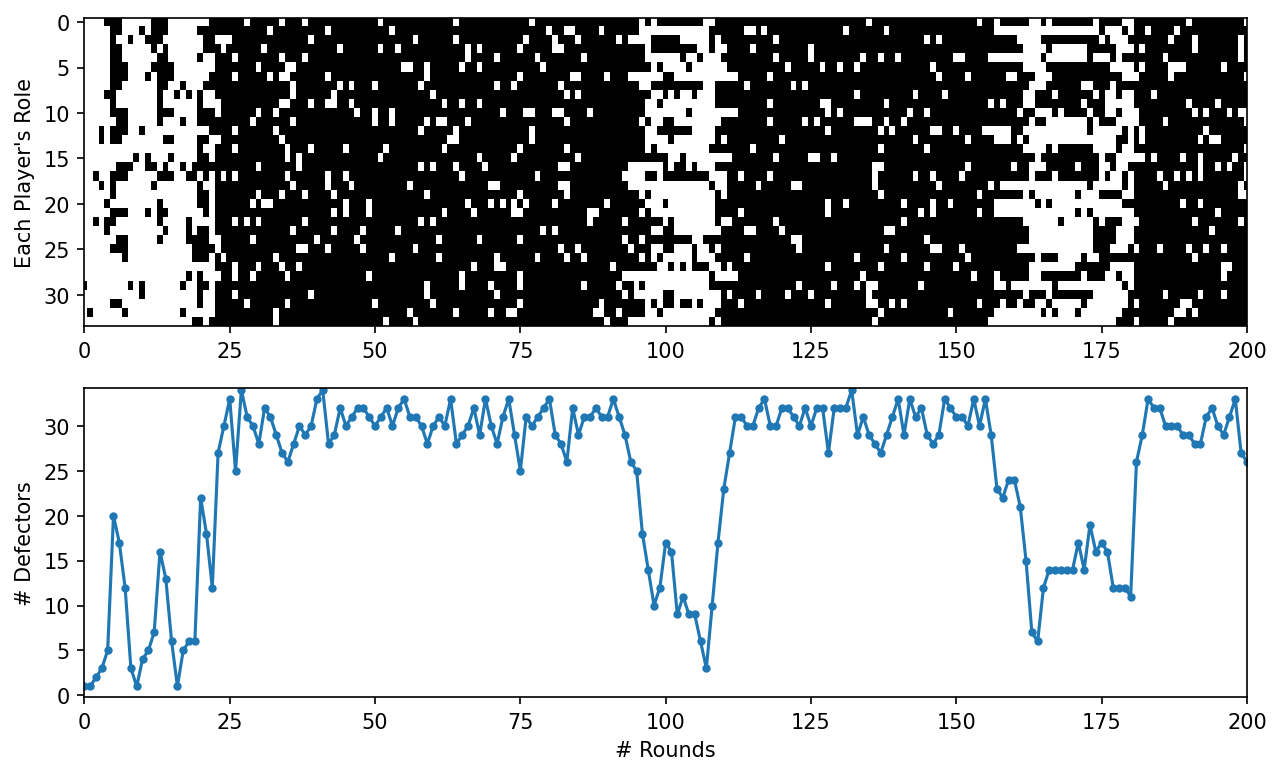

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[10, 6],
                               dpi=150)

ax1.imshow(history.T, cmap='Greys', aspect='auto')
ax2.plot(num_defectors, '.-')
ax2.set_ylim([0-0.2, G.number_of_nodes()+0.2])
for ax in [ax1, ax2]:
    ax.set_xlim([0, num_games])
#
ax1.set_ylabel("Each Player's Role")
ax2.set_xlabel('# Rounds')
ax2.set_ylabel('# Defectors')
plt.show()

## How does the network change?

Original network


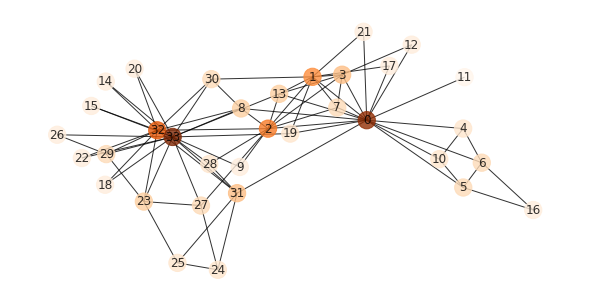

After some rewiring


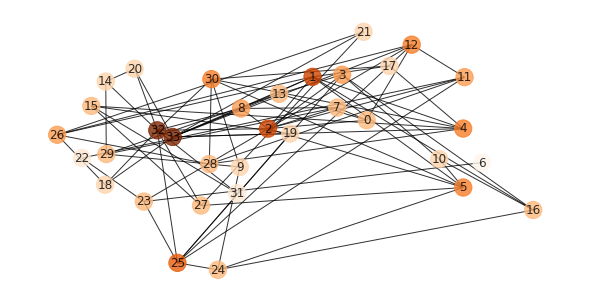

In [63]:
print('Original network')
draw_centrality(G_unrewired, pos=pos, figsize=[8, 4])

print('After some rewiring')
draw_centrality(G, pos=pos, figsize=[8, 4])

# What if you can control the strategy of the winner?

In [64]:
def make_winner_collaborate(G, role, points):
    # find player with highest score
    highest_score = np.max(points)
    winner = find_player_by_pointvalue(points, highest_score)
    # force winner to collaborate
    role[winner] = 0
    return role

Init: 0 defectors
Initialization


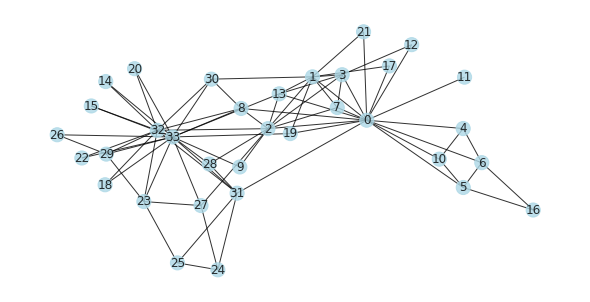

Round 20


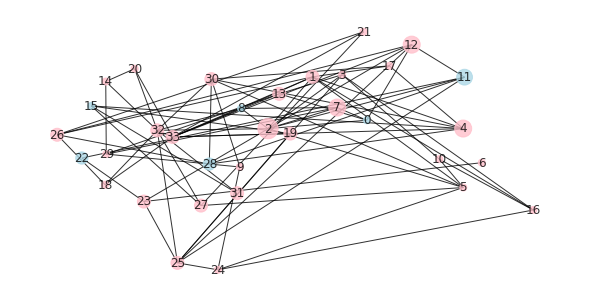

Round 40


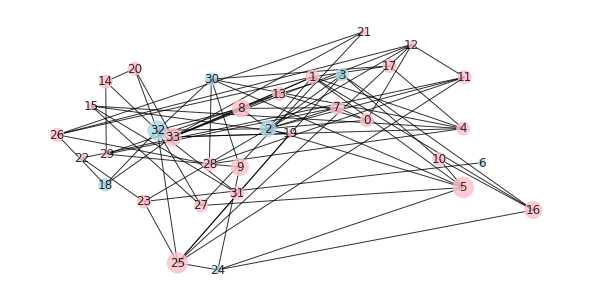

Round 60


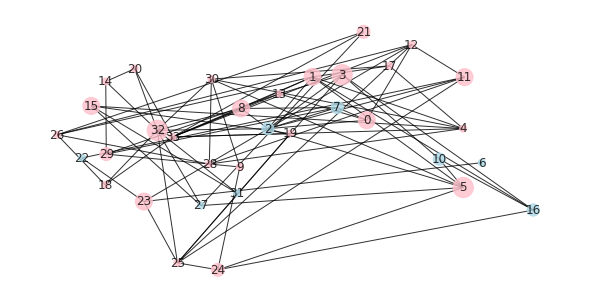

Round 80


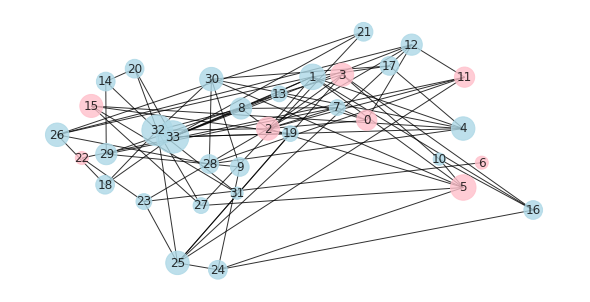

Round 100


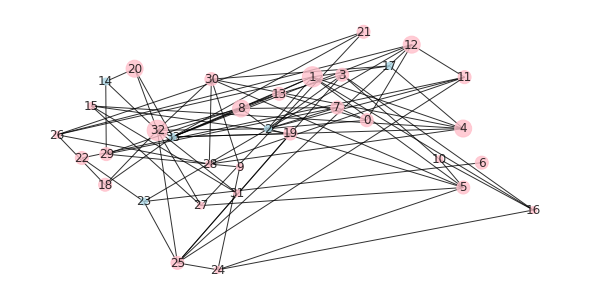

In [65]:
num_D = 0
G, roles = random_karateclub(num_D)  # start with num_D

print('Initialization')
draw_defectors(G, roles, pos=pos, figsize=[8, 4])

# Try playing with these variables
pts_DC = 1.2  # points won by defector, >0
pts_CC = 1    # points for collaborating, >0
p_m = 0.1     # error rate when choosing strategy
num_games = 100
show_games = 20

# Tracking history and number of defectors
history = np.zeros([num_games + 1, G.number_of_nodes()])
history[0, :] = roles
num_defectors = np.zeros(num_games + 1)
num_defectors[0] = sum(roles)

# Play game!
for game in range(num_games):
    # calculate points
    points = get_points(G, roles, 
                    pts_DC=pts_DC, 
                    pts_CC=pts_CC)
    # show what happened every few rounds
    if (game+1) % show_games == 0:
        print(f'Round {game + 1}')
        draw_defectors(G, roles, 
                   pos=pos,
                   sizes=points*100+50, 
                   figsize=[8, 4])
    # choose new strategy
    new_roles = get_new_mutrole(G, roles, points, 
                                p_m=p_m)
    # MAKE WINNER COLLABORATE
    new_roles = make_winner_collaborate(G, new_roles, points)
    # update for next round of the game
    roles = new_roles
    G = new_G
    # track information
    history[game + 1, :] = roles
    num_defectors[game + 1] = np.sum(roles)

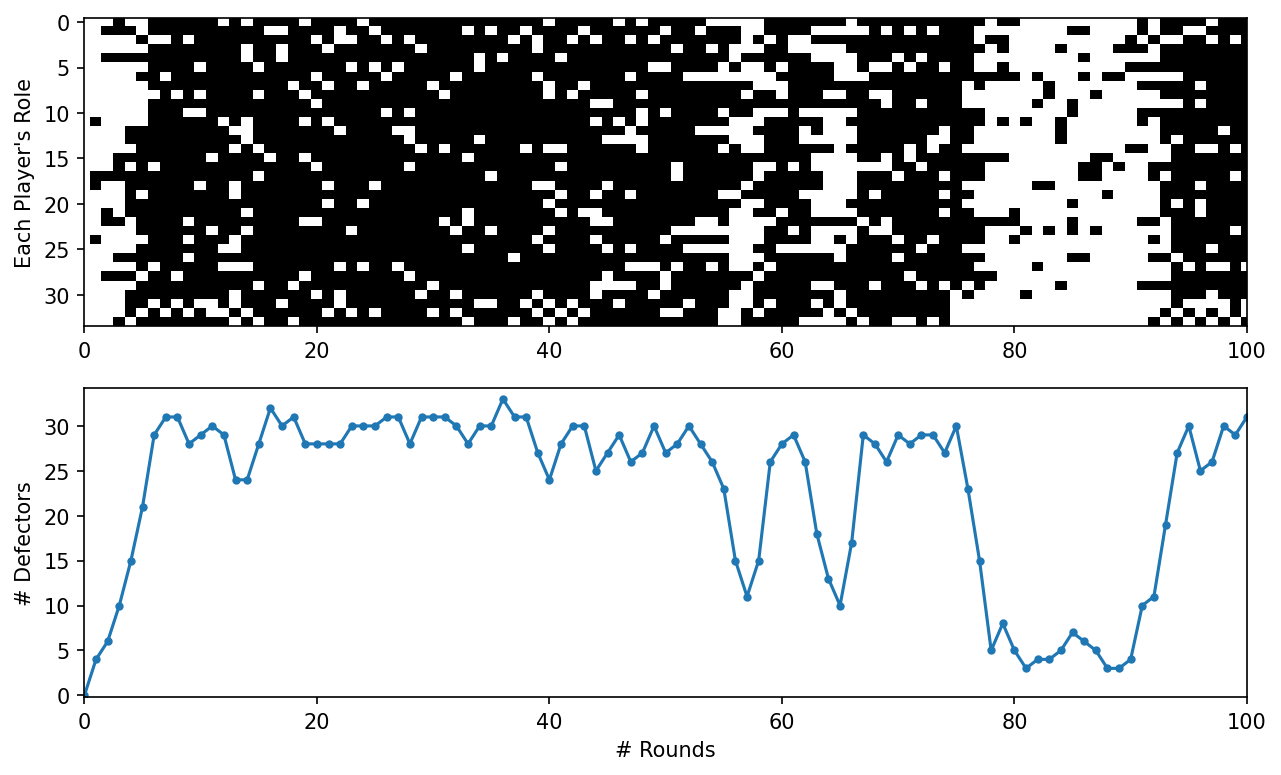

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[10, 6],
                               dpi=150)

ax1.imshow(history.T, cmap='Greys', aspect='auto')
ax2.plot(num_defectors, '.-')
ax2.set_ylim([0-0.2, G.number_of_nodes()+0.2])
for ax in [ax1, ax2]:
    ax.set_xlim([0, num_games])
#
ax1.set_ylabel("Each Player's Role")
ax2.set_xlabel('# Rounds')
ax2.set_ylabel('# Defectors')
plt.show()